# Online data processing

This notebook illustrates how to feedback online data analysis results back to the experiment using _Beacon channels_.

In [1]:
import os
import gevent
from bliss.data.scan import ScansWatcher, ScansObserver

/users/denolf/virtualenvs/bliss_jup/ubuntu_20_04/lib/python3.7/site-packages/tango/utils.py:181: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CmdArgType.DevString: numpy.str,


## Plot helper

Updateable matplotlib graphs

In [2]:
import matplotlib.pyplot as plt
from IPython import display

class Plotter:
    def __init__(self, max_plots=5):
        self.plots = list()
        self.fig = None
        self.max_plots = max_plots

    def update_plot_data(self, plot, label, x, y):
        if self.fig is None:
            self.fig, self.ax = plt.subplots(figsize=(10,6))
            self.hdisplay = display.display("", display_id=True)

        if plot is None:
            label = label.split(":")[-1]
            while label.startswith("_"):
                label = label[1:]
            plot = self.ax.plot(x, y, label=label)[0]
            self.plots.append(plot)
        else:
            plot.set_xdata(x)
            plot.set_ydata(y)

        self.update_display()
        return plot

    def update_display(self):
        if self.fig is None:
            return
        self.ax.relim()
        self.ax.autoscale()
        self.ax.legend()
        self.hdisplay.update(self.fig)

    def purge_plots(self):
        while len(self.plots) > self.max_plots:
            plot = self.plots.pop(0)
            plot.remove()
        self.update_display()

/users/denolf/virtualenvs/bliss_jup/ubuntu_20_04/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Scan data watcher

A loop that runs forever and received all scan data related to a specific BLISS session

In [3]:
def watch_scans(session_name):
    watcher = ScansWatcher(session_name)
    watcher.set_observer(ScanObserver(max_plots=3))

    print("Start data processing ...", flush=True)
    try:
        watcher.run()
    except KeyboardInterrupt:
        pass
    print("Data processing stopped", flush=True)

/users/denolf/virtualenvs/bliss_jup/ubuntu_20_04/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Data processing

Send a response to the experiment after a scan is finished.

In [4]:
import numpy
from bliss.config.channels import Channel

class ScanObserver(ScansObserver):
    def __init__(self, *args, max_plots=5, **kw):
        super().__init__(*args, **kw)
        self.scan_data = dict()
        self.plotter = Plotter(max_plots=max_plots)

        self.counter = 0
        self.odastate = {"is_oda_feedback": True}
        self.odachannel = Channel(
            "oda_feedback", callback=self.receive, default_value=self.odastate 
        )

    def receive(self, odastate):
        if odastate.get("is_oda_feedback"):
            return
        self.odastate.update(odastate)
        if odastate.get("stop"):
            self.counter = 0

    def send(self):
        self.odastate["is_oda_feedback"] = True
        self.odachannel.value = self.odastate

    def on_scan_started(self, scan_db_name, scan_info):
        self.scan_data[scan_db_name] = {"data": [], "plot": None}

    def on_scan_finished(self, scan_db_name, scan_info):
        self.oda_response(scan_db_name)
        self.scan_data.pop(scan_db_name)
        self.plotter.purge_plots()

    def on_scalar_data_received(
        self, scan_db_name, channel_name, index, data_bunch
    ):
        if channel_name == self.odastate.get("counter"):
            self.append_data(scan_db_name, "data", data_bunch)

    def append_data(self, scan_db_name, key, values):
        info = self.scan_data[scan_db_name]
        y = info[key] = numpy.append(info[key], values)
        x = numpy.arange(y.size)
        info["plot"] = self.plotter.update_plot_data(
                info["plot"], scan_db_name, x, y
            )

    def oda_response(self, scan_db_name):
        # This should make a decission based on the data.
        # For illustration use a simple counter.
        self.counter += 1
        if self.counter < self.plotter.max_plots:
            self.odastate["stop"] = False
        else:
            self.counter = 0
            self.odastate["stop"] = True
        self.send()

## Connect and receive Redis data

Run this command in the shell:
 user_script_homedir("path/to/bliss_oda_examples")
 user_script_load("blissdemoscript.py")
 user.experiment_with_oda_feedback()

Start data processing ...


/users/denolf/virtualenvs/bliss_jup/ubuntu_20_04/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


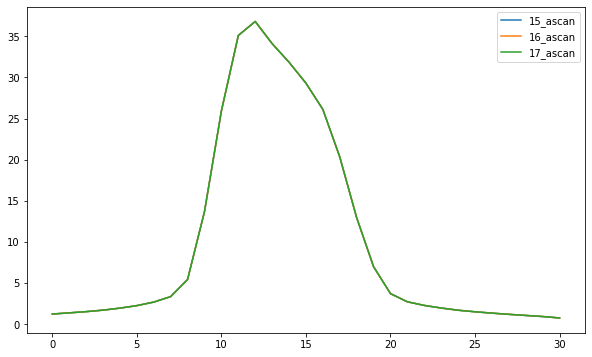

In [ ]:
os.environ["BEACON_HOST"] = "localhost:10001"

print("Run this command in the shell after starting the notebook:")
print(' user_script_homedir("path/to/bliss_oda_examples")')
print(' user_script_load("blissdemoscript.py")')
print(" user.experiment_with_oda_feedback()")
print("")

watch_scans("demo_session")